# Introduction

**This code contains three parts, including original features analysis, tweet data analysis and text cleaning.**

* Original features analysis:
    * Visualization
    * Statistical analysis
* Tweet data analysis:
    * Metafeature
    * N-gram analysis
    * Wordcloud
* Text Cleaning

# Load libraries and Data Preparation

In [1]:
import re
import string
import emoji

import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import seaborn as sns
import warnings
import math

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/chatgpt-twitter/chatgpt.csv')
print('shape = {}'.format(df.shape))
df.info()

shape = (219294, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tweet_id       219294 non-null  int64 
 1   created_at     219294 non-null  object
 2   like_count     219294 non-null  int64 
 3   quote_count    219294 non-null  int64 
 4   reply_count    219294 non-null  int64 
 5   retweet_count  219294 non-null  int64 
 6   tweet          219294 non-null  object
 7   country        3648 non-null    object
 8   photo_url      68446 non-null   object
 9   city           3648 non-null    object
 10  country_code   3645 non-null    object
dtypes: int64(5), object(6)
memory usage: 18.4+ MB


In [3]:
# check missing value
df.isnull().sum()

tweet_id              0
created_at            0
like_count            0
quote_count           0
reply_count           0
retweet_count         0
tweet                 0
country          215646
photo_url        150848
city             215646
country_code     215649
dtype: int64

In [4]:
# check duplicate ids
df[df['tweet_id'].duplicated()]

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
281,1598083990212476928,2022-11-30 22:38:08+00:00,12,1,1,3,Me: Tell me a story about a cybernetic shrimp ...,NaN,https://pbs.twimg.com/media/Fi2I0uqVsAAL5Qf.jpg,NaN,NaN


In [5]:
df[df['tweet_id'] == 1598083990212476928]

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
280,1598083990212476928,2022-11-30 22:38:08+00:00,11,1,1,3,Me: Tell me a story about a cybernetic shrimp ...,NaN,https://pbs.twimg.com/media/Fi2I0uqVsAAL5Qf.jpg,NaN,NaN
281,1598083990212476928,2022-11-30 22:38:08+00:00,12,1,1,3,Me: Tell me a story about a cybernetic shrimp ...,NaN,https://pbs.twimg.com/media/Fi2I0uqVsAAL5Qf.jpg,NaN,NaN


In [6]:
print("Original:", df.shape)
df.drop(281, inplace=True, axis=0)
df = df.reset_index(drop=True)
print("After:", df.shape)

Original: (219294, 11)
After: (219293, 11)


In [7]:
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...,NaN,NaN,NaN,NaN
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh...",NaN,NaN,NaN,NaN
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...,NaN,https://pbs.twimg.com/media/Fi1J8HbWAAMv_yi.jpg,NaN,NaN
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ...",NaN,https://pbs.twimg.com/media/Fi1Km3WUYAAfzHS.jpg,NaN,NaN
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne...",NaN,NaN,NaN,NaN


# 1. Original features analysis
## 1.1 Visualization
### ①Pairplot

Plot the pairwise relationships in the dataset.

In [8]:
# Spend much time (see result in file)
df_new = df[['tweet_id', 'like_count', 'quote_count', 'reply_count', 'retweet_count']]
# sns.pairplot(df_new)
# plt.savefig('Pairplot.png')

### ②Histogram

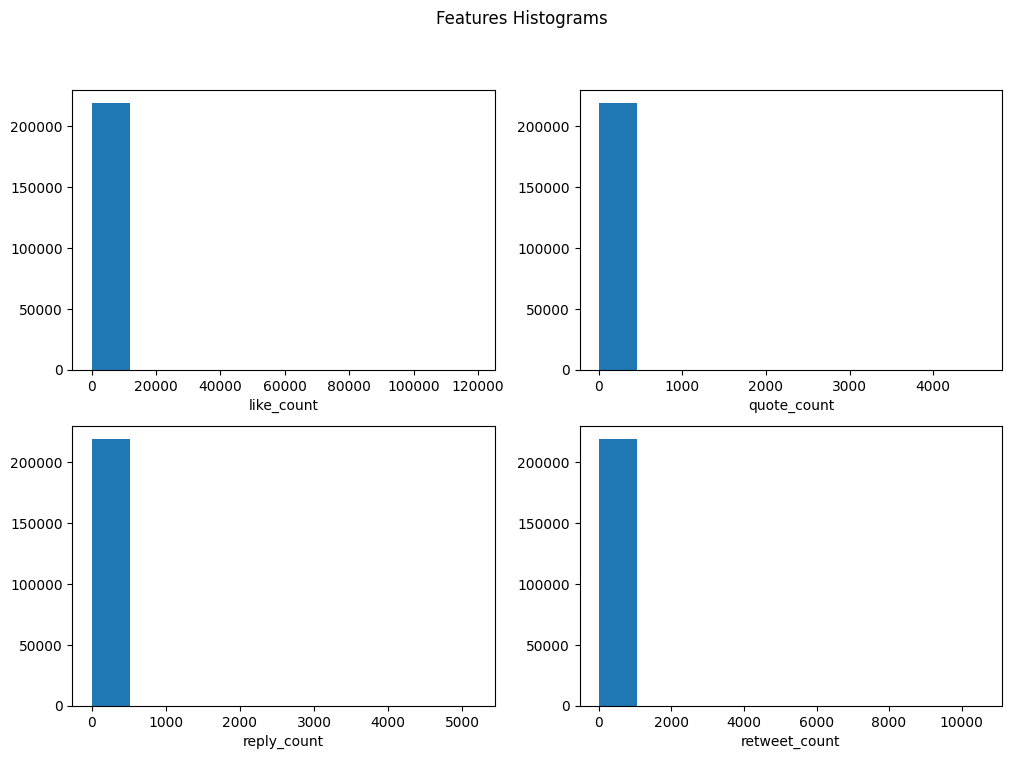

In [9]:
features = ['like_count', 'quote_count', 'reply_count', 'retweet_count']
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=2)

for i, ax in enumerate(axes.flat):
    ax.hist(df[features[i]])
    ax.set_xlabel(features[i])

fig.suptitle('Features Histograms')
plt.savefig('Features_Histogram.png')
plt.show()

### ③Heatmap

时间列（字符串类型）：对于时间列，考虑将其转换为日期时间类型，然后提取出数值特征，例如年份、月份、季度等。然后可以使用这些数值特征计算相关性。

文本列（字符类型）：对于文本列，考虑将其转换为数值特征，例如使用词频向量化（如词袋模型、TF-IDF等）将文本转换为数值特征表示。然后可以使用这些数值特征计算相关性。

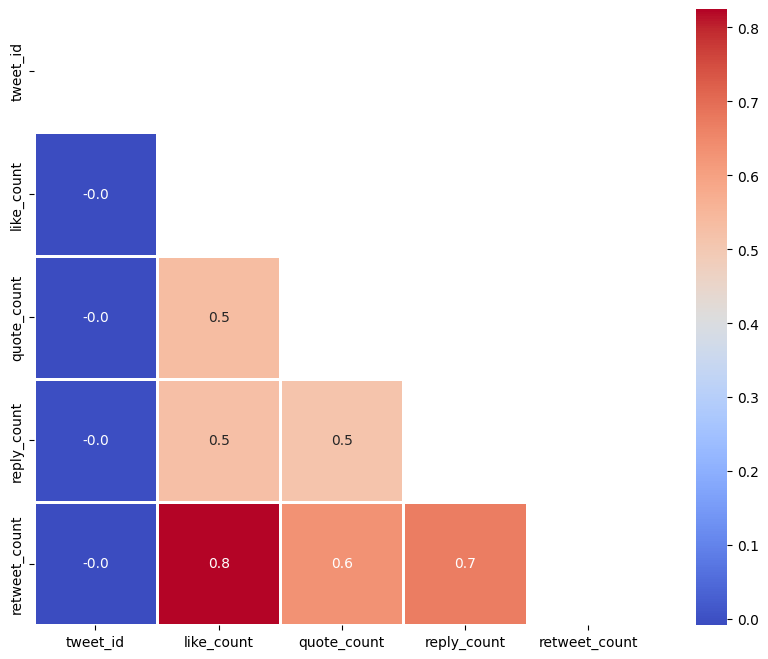

In [10]:
plt.figure(figsize=(12,8))
correlation_matrix = df_new.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix,mask=mask,cmap='coolwarm',annot=True,square=True,fmt='.1f',linewidths=1)

plt.savefig('Heatmap.png')
plt.show()

### ④Boxplot

A boxplot is a standardized way of displaying the dataset based on 
the five-number summary: the minimum, the maximum, the sample median, 
and the first and third quartiles.

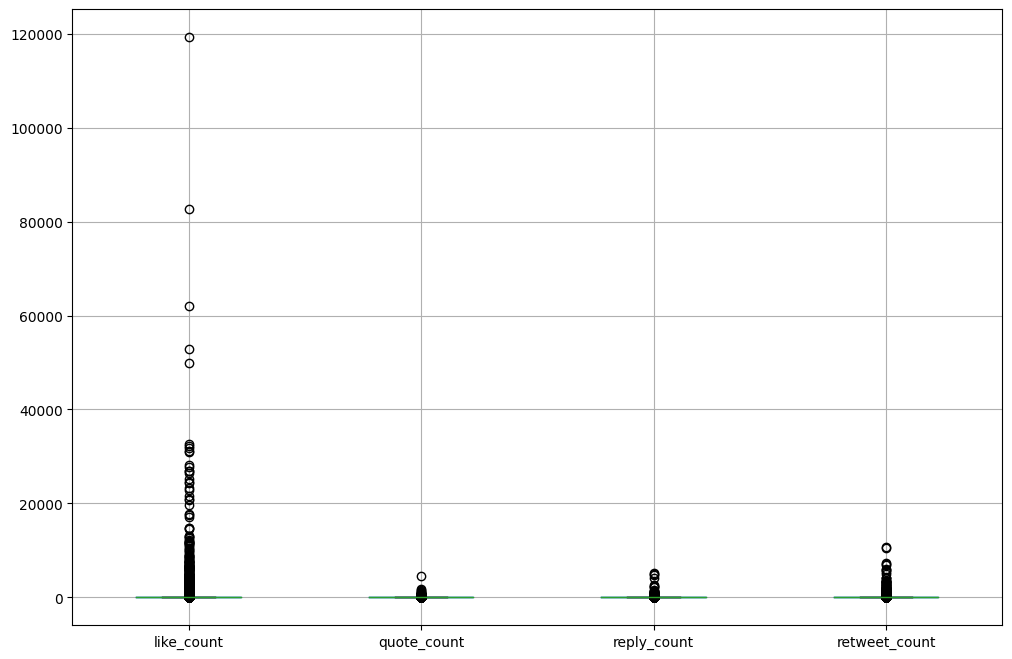

In [11]:
plt.figure(figsize=(12,8))
df[['like_count', 'quote_count', 'reply_count', 'retweet_count']].boxplot()
plt.savefig('Boxplot.png')

## 1.2 Statistical analysis

### ①Distribution of the number of tweets per day

In [12]:
!pip install pyecharts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.3/146.3 kB 3.3 MB/s eta 0:00:00


In [13]:
from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.charts import Line
from pyecharts.charts import Map

data = df.copy()
data['created_at'] = pd.to_datetime(data['created_at'])
data_per_day = data.groupby(data['created_at'].apply(lambda x: x.strftime("%D"))).agg({'tweet_id':'count'}).to_dict()['tweet_id']
x = [*data_per_day.keys()]
y = [*data_per_day.values()]
c = (
    Bar()
    .add_xaxis(x)
    .add_yaxis("Tweet number", y)
    .set_global_opts(title_opts=opts.TitleOpts(title="Number of Tweets Per Day"))
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="Peak"),
                opts.MarkPointItem(type_="min", name="Minimum"),
                opts.MarkPointItem(type_="average", name="Mean"),
            ]
        ),
    )
)
c.render('Tweets Per Day.html')
c.render_notebook()

### ②Distribution of active time per hour

Visualize the distribution of daily active tweets for a month.

In [14]:
data_per_hour = data.groupby(data['created_at'].apply(lambda x: x.strftime("%H"))).agg({'tweet_id':'count'}).to_dict()['tweet_id']
x = [*data_per_hour.keys()]
y = [*data_per_hour.values()]
c = (
    Line()
    .add_xaxis(x)
    .add_yaxis("Tweet number", y)
    .set_global_opts(title_opts=opts.TitleOpts(title="Number of Tweets Per Hour"))
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="Peak"),
                opts.MarkPointItem(type_="min", name="Minimum"),
                opts.MarkPointItem(type_="average", name="Mean"),
            ]
        ),
    )
)
c.render('Tweets Per Hour.html')
c.render_notebook()

In [15]:
like_count = data.groupby(data['created_at'].apply(lambda x: x.strftime("%H"))).agg({'like_count':'sum'}).to_dict()['like_count']
quote_count = data.groupby(data['created_at'].apply(lambda x: x.strftime("%H"))).agg({'quote_count':'sum'}).to_dict()['quote_count']
reply_count = data.groupby(data['created_at'].apply(lambda x: x.strftime("%H"))).agg({'reply_count':'sum'}).to_dict()['reply_count']
retweet_count =  data.groupby(data['created_at'].apply(lambda x: x.strftime("%H"))).agg({'retweet_count':'sum'}).to_dict()['retweet_count']


x = [*like_count.keys()]
c = (
    Line()
    .add_xaxis(x)
    .add_yaxis("Like count", [*like_count.values()])
    .add_yaxis("Quote count", [*quote_count.values()])
    .add_yaxis("Reply count", [*reply_count.values()])
    .add_yaxis("Retweet count", [*retweet_count.values()])
    .set_global_opts(title_opts=opts.TitleOpts(title="Tweets Activity Per Hour"))
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="Peak"),
                opts.MarkPointItem(type_="min", name="Minimum"),
            ]
        ),
    )
)
c.render('Tweets Activity Per Hour.html')
c.render_notebook()

### ③User and Activity Distribution Map

In [16]:
df['country'].value_counts()

country
United States     1673
India              324
United Kingdom     259
Canada             183
Australia          106
                  ... 
Bermuda              1
Belize               1
Cayman Islands       1
Vietnam              1
Panama               1
Name: count, Length: 110, dtype: int64

In [17]:
data_country = data.groupby('country').agg({'tweet_id':'count'})
tweet_id = data_country.to_dict()['tweet_id']
c = (
    Map()
    .add("Tweet Number", [*tweet_id.items()], "world", is_map_symbol_show=False)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        title_opts=opts.TitleOpts(title='User Distribution'),
        visualmap_opts=opts.VisualMapOpts(max_=1500),
    )
)
c.render("User Distribution.html")
c.render_notebook() 

In [18]:
like_count = data.groupby('country').agg({'like_count':'sum'}).to_dict()['like_count']
quote_count = data.groupby('country').agg({'quote_count':'sum'}).to_dict()['quote_count']
reply_count = data.groupby('country').agg({'reply_count':'sum'}).to_dict()['reply_count']
retweet_count =  data.groupby('country').agg({'retweet_count':'sum'}).to_dict()['retweet_count']

c = (
    Map()
    .add("Like", [*like_count.items()], "world", is_map_symbol_show=False)
    .add("Quote", [*quote_count.items()], "world", is_map_symbol_show=False)
    .add("Reply", [*reply_count.items()], "world", is_map_symbol_show=False)
    .add("Retweet", [*retweet_count.items()], "world", is_map_symbol_show=False)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        title_opts=opts.TitleOpts(title='User Activity Distribution'),
        visualmap_opts=opts.VisualMapOpts(max_=1500),
    )
)
c.render("User Activity Distribution.html")
c.render_notebook() 

# 2. Tweet Data analysis

In [19]:
print('Length Statistics')
df['tweet'].apply(len).describe()

Length Statistics


count    219293.000000
mean        144.716835
std          80.144913
min           7.000000
25%          80.000000
50%         124.000000
75%         207.000000
max         357.000000
Name: tweet, dtype: float64

## 2.1 Visual data distribution

In [20]:
# metafeature examples
x = df['tweet'][3]
print(x)
char_count_example = len(str(x))
word_count_example = len(str(x).split())
word_length_example = [len(w) for w in str(x).split()]
unique_word_example = set(str(x).split())

print()
print('char count example: {}'.format(char_count_example))
print('word count example: {}'.format(word_count_example))
print('word length example: {}'.format(word_length_example))
print('unique word example: {}'.format(unique_word_example))

THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71

char count example: 188
word count example: 22
word length example: [8, 2, 5, 4, 8, 3, 3, 5, 9, 3, 7, 2, 3, 7, 5, 3, 10, 2, 9, 23, 23, 23]
unique word example: {'https://t.co/dyvtHecYbd', 'is', 'THRILLED', 'for', 'dialog,', 'optimized', 'new', 'https://t.co/l8qTLure71', 'accessible', 'now', 'to', 'our', 'share', 'model', 'public,', 'ChatGPT,', 'https://t.co/DdhzhqhCBX', 'and', 'that', 'everyone.', 'free,'}


In [21]:
meta = pd.DataFrame()
# char_count
meta['char_count'] = df['tweet'].apply(lambda x: len(str(x)))

# word_count
meta['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))

# mean_word_length
meta['mean_word_length'] = df['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# unique_word_count
meta['unique_word_count'] = df['tweet'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
meta['stop_word_count'] = df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
meta['url_count'] = df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# punctuation_count
meta['punctuation_count'] = df['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
meta['hashtag_count'] = df['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
meta['mention_count'] = df['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))

meta.to_csv('metafeatures.csv')
meta

,char_count,word_count,mean_word_length,unique_word_count,stop_word_count,url_count,punctuation_count,hashtag_count,mention_count
0,80,8,9.125000,8,1,1,7,0,1
1,139,21,5.666667,21,6,1,8,0,0
2,264,26,9.192308,26,3,2,22,4,0
3,188,22,7.590909,21,7,3,20,0,0
4,139,20,6.000000,20,6,2,15,0,1
...,...,...,...,...,...,...,...,...,...
219288,83,10,7.400000,10,3,1,5,0,0
219289,238,42,4.690476,37,16,0,14,4,0
219290,57,9,5.444444,9,6,0,0,0,0
219291,173,27,5.444444,27,9,1,11,1,0


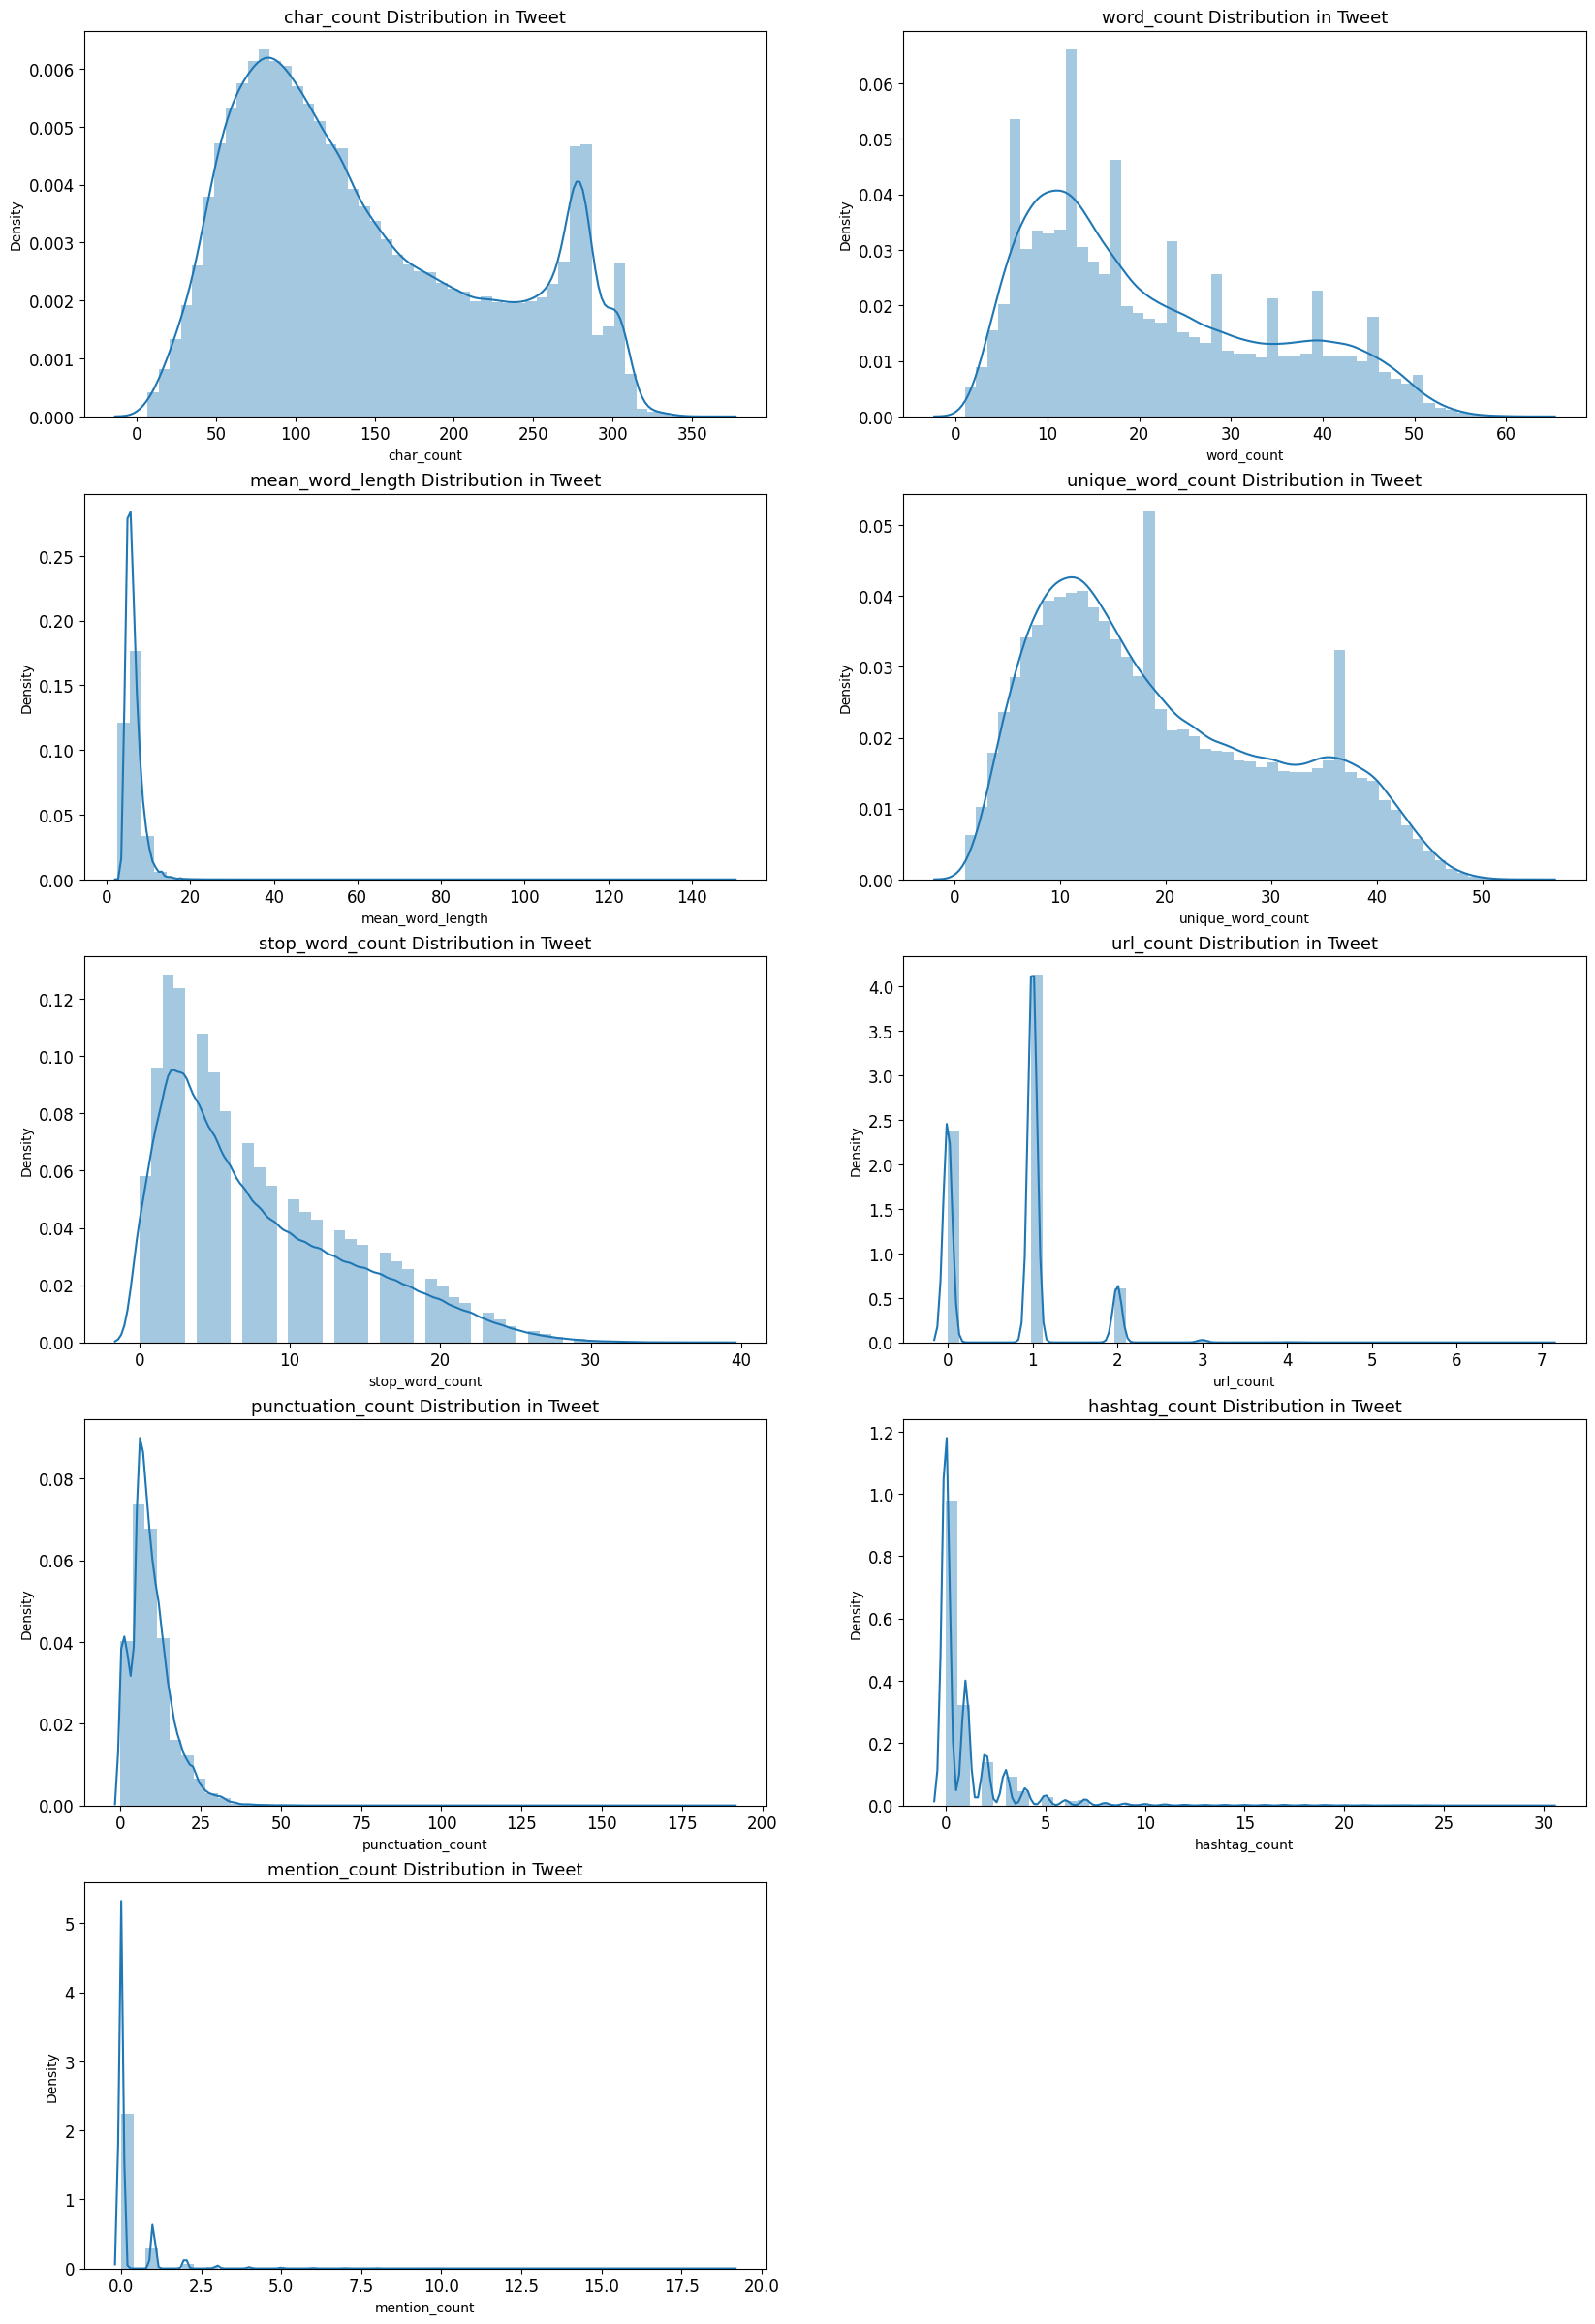

In [22]:
METAFEATURES = ['char_count', 'word_count', 'mean_word_length', 'unique_word_count', 'stop_word_count', 'url_count', 
                'punctuation_count', 'hashtag_count', 'mention_count']

num_features = len(METAFEATURES)
num_cols = 2
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(20, 30), dpi=100)  

for i, feature in enumerate(METAFEATURES):
    row = i // num_cols
    col = i % num_cols

    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='x', labelsize=12)
    axes[row, col].tick_params(axis='y', labelsize=12)

    sns.distplot(meta[feature], ax=axes[row, col])

    axes[row, col].set_title(f'{feature} Distribution in Tweet', fontsize=13)

if num_features % num_cols != 0:
    for j in range(num_features % num_cols, num_cols):
        fig.delaxes(axes[num_rows - 1, j])

# plt.savefig('metafeatures.png')
plt.show()

## 2.2 N-gram Analysis

Do a bigram (n=2) analysis over the tweets and check the most common bigrams in tweets.

<Axes: >

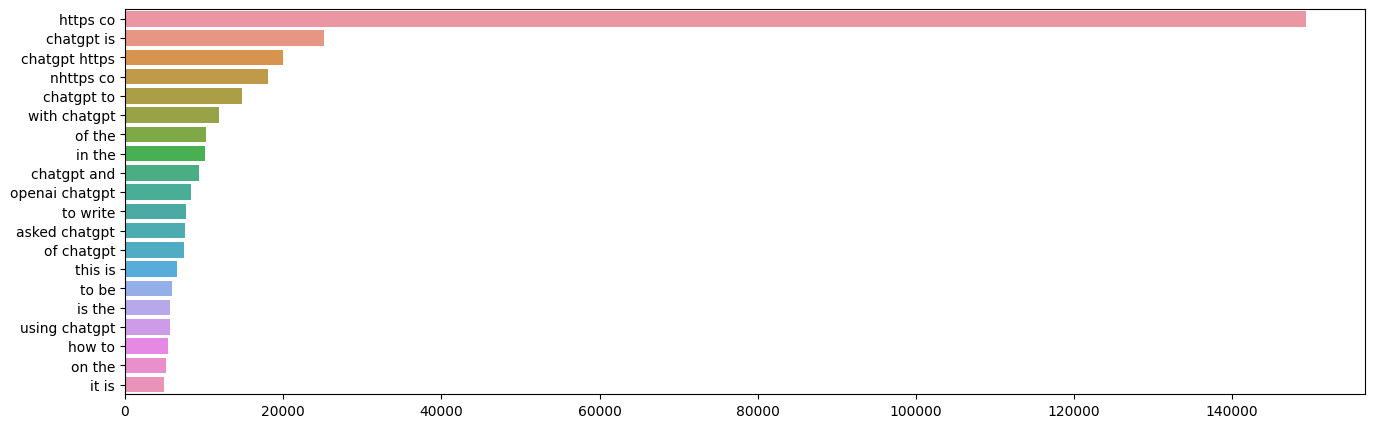

In [23]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df['tweet'], n=20)
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
# plt.savefig('top 20 bigrams.png')

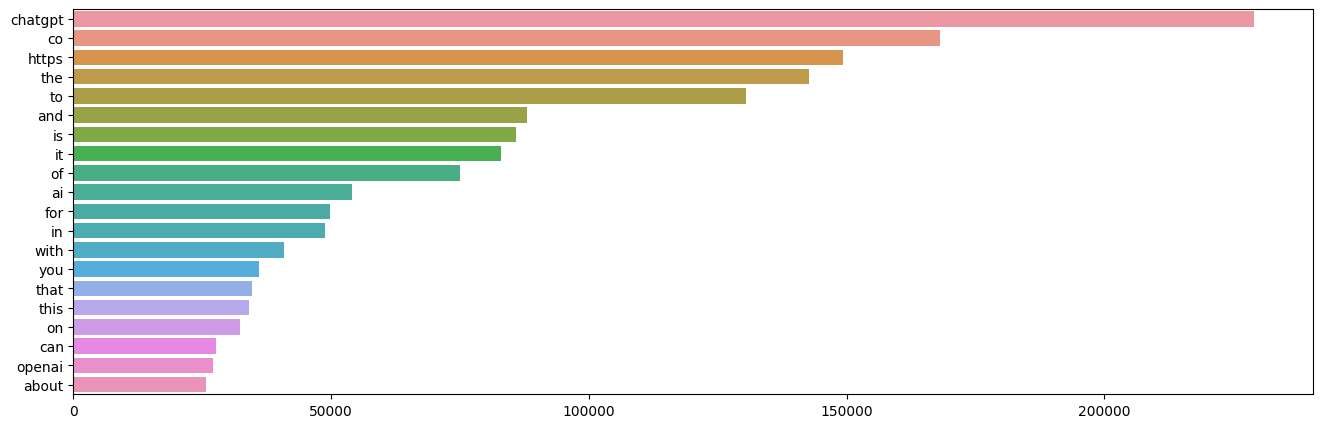

In [24]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_unigrams(df['tweet'], n=20)
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.savefig('top 20 unigrams.png')

## 2.3 Wordcloud

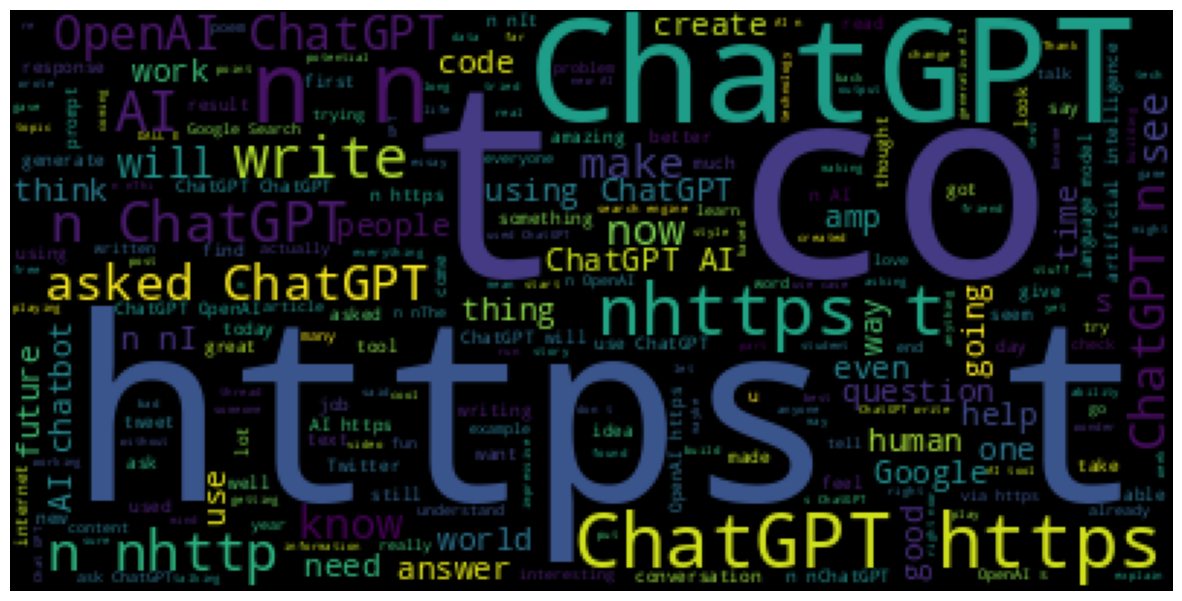

In [25]:
plt.figure(figsize=(15,10))
text=' '.join(df['tweet'])
wordcloud = WordCloud(max_words=500,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud_original.png')
plt.show()

# 3. Text Cleaning

In [26]:
def clean(tweet):
    
    # Change to lower characters
    tweet = tweet.lower()
    
    # remove Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    
    # remove hashtags
    tweet = re.sub(r"#", "", tweet)
    
    # remove mentions
    tweet = re.sub(r"@", "", tweet)

    # Convert emoji to text
    tweet = emoji.demojize(tweet)
    
    # remove hyperlinks
    tweet = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub('&gt;', "", tweet) # greater than sign
    tweet = re.sub('&#x27;', "'", tweet) # apostrophe
    tweet = re.sub('&#x2F;', ' ', tweet)
    tweet = re.sub('<p>', ' ', tweet) # paragraph tag
    tweet = re.sub('<i>', ' ', tweet) #italics tag
    tweet = re.sub('</i>', '', tweet) 
    tweet = re.sub('&#62;', '', tweet)
    tweet = re.sub("\n", '', tweet) # newline 

    return tweet

In [27]:
df['tweet_cleaned'] = df['tweet'].apply(lambda t : clean(t))

In [28]:
# check the cleaned tweet
t = 3
print('The original: {}'.format(df.iloc[t]['tweet']))
print('The cleaned: {}'.format(df.iloc[t]['tweet_cleaned']))

The original: THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71
The cleaned: thrilled to share that chatgpt, our new model optimized for dialog, is now public, free, and accessible to everyone.   


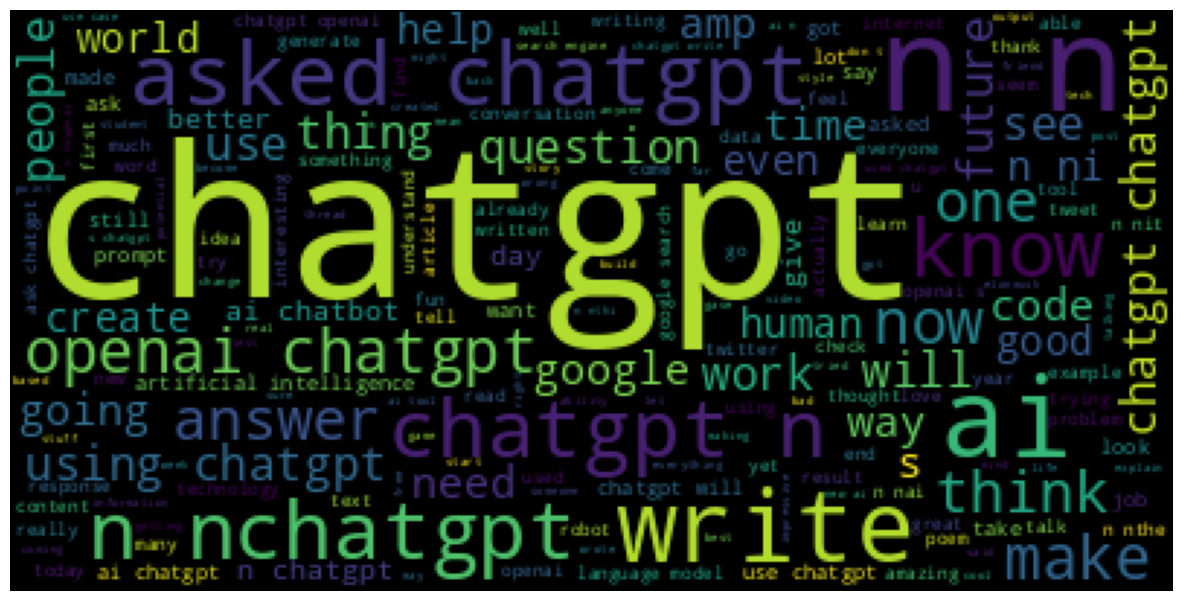

In [29]:
plt.figure(figsize=(15,10))
text=' '.join(df['tweet_cleaned'])
wordcloud = WordCloud(max_words=500,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud_cleaned.png')
plt.show()

In [30]:
df = df[['tweet_id', 'tweet', 'tweet_cleaned']]
df.head()

,tweet_id,tweet,tweet_cleaned
0,1598014056790622225,ChatGPT: Optimizing Language Models for Dialog...,chatgpt: optimizing language models for dialog...
1,1598014522098208769,"Try talking with ChatGPT, our new AI system wh...","try talking with chatgpt, our new ai system wh..."
2,1598014741527527435,ChatGPT: Optimizing Language Models for Dialog...,chatgpt: optimizing language models for dialog...
3,1598015493666766849,"THRILLED to share that ChatGPT, our new model ...","thrilled to share that chatgpt, our new model ..."
4,1598015509420994561,"As of 2 minutes ago, @OpenAI released their ne...","as of 2 minutes ago, openai released their new..."


In [31]:
df.to_csv("chatgpt_cleaned.csv")